In [1]:
# allows imports from parent folders
from prep import prep_nbook
prep_nbook()

import sklearn.datasets as datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torchdiffeq

from torchdyn.models import *; from torchdyn.data_utils import *
from torchdyn import *

# Augmentation strategies 

In this notebook we explore different augmentation strategies for neural differential equations. This time, we'll make use of the 3D `concentric spheres` dataset.

In [2]:
d = ToyDataset()
X, yn = d.generate(n_samples=2**13, dataset_type='spheres')        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
bs = len(X)

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)

train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=bs, shuffle=False)

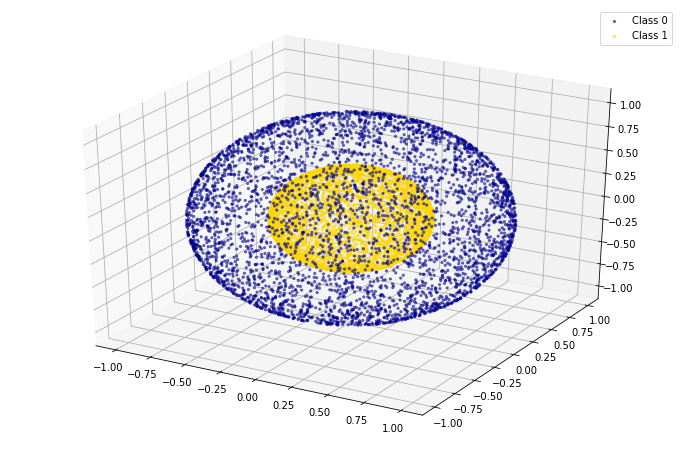

In [4]:
c = ['darkblue', 'gold']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for i in range(2):
    ax.scatter(X[yn==i,0], X[yn==i,1], X[yn==i,2], s=5, alpha=0.5, c=c[i])
plt.legend(["Class %d" % i for i in range(2)]);

In [5]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        defaults.update(settings)
        self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

## Neural ODE (0--augmentation)

The first model under consideration involves 0--augmentation, and is often referred to as [ANODE](https://arxiv.org/abs/1904.01681). With `torchdyn`, turning a neural ODE into an ANODE is as simple as using the `Augmenter` class as follows:

In [6]:
settings = {'type':'classic', 'controlled':False, 'solver':'dopri5'}

In [7]:
func = DEFunc(nn.Sequential(nn.Linear(8,80),
                            nn.Tanh(),
                            nn.Linear(80,8))
                            )

In [8]:
neuralDE = NeuralDE(func, settings).to(device)

model = nn.Sequential(Augmenter(augment_dims=5),
                      neuralDE,
                      nn.Linear(8,2)).to(device)

Note that `Augmenter` can be fully-specified outside the neuralDE model. This makes it straightforward to switch between augmented and non-augmented at will.

In [9]:
learn = Learner(model, settings)
trainer = pl.Trainer(max_nb_epochs=300)
trainer.fit(learn)

INFO:lightning:
  | Name               | Type       | Params
----------------------------------------------
0 | model              | Sequential | 1 K   
1 | model.0            | Augmenter  | 0     
2 | model.1            | NeuralDE   | 1 K   
3 | model.1.defunc     | DEFunc     | 1 K   
4 | model.1.defunc.m   | Sequential | 1 K   
5 | model.1.defunc.m.0 | Linear     | 720   
6 | model.1.defunc.m.1 | Tanh       | 0     
7 | model.1.defunc.m.2 | Linear     | 648   
8 | model.1.adjoint    | Adjoint    | 0     
9 | model.2            | Linear     | 18    


/home/jyp/.local/share/virtualenvs/GNODE--9w4TJnR/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)
/home/jyp/.local/share/virtualenvs/GNODE--9w4TJnR/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

## Neural ODE (Input-Layer (IL)-Augmentation) 

Input layer augmentation ([IL-augmentation](https://arxiv.org/abs/2002.08071)) is also easy to implement with `torchdyn`. The following is an example of a partial IL-augmentation where a linear layer is trained to determine the initial condition of the additional `5` dimensions. Notice how the `DEFunc` goes from `8` to `8` dimensions. 

In [10]:
settings = {'type':'classic', 'controlled':False, 'solver':'dopri5'}

In [11]:
func = DEFunc(nn.Sequential(nn.Linear(8,80),
                            nn.Tanh(),
                            nn.Linear(80,8))
                            )

In [12]:
neuralDE = NeuralDE(func, settings).to(device)

model = nn.Sequential(Augmenter(augment_func=nn.Linear(3, 5)),
                      neuralDE,
                      nn.Linear(8,2)).to(device)

In [13]:
learn = Learner(model, settings)
trainer = pl.Trainer(max_nb_epochs=300)
trainer.fit(learn)

INFO:lightning:
   | Name                 | Type       | Params
------------------------------------------------
0  | model                | Sequential | 1 K   
1  | model.0              | Augmenter  | 20    
2  | model.0.augment_func | Linear     | 20    
3  | model.1              | NeuralDE   | 1 K   
4  | model.1.defunc       | DEFunc     | 1 K   
5  | model.1.defunc.m     | Sequential | 1 K   
6  | model.1.defunc.m.0   | Linear     | 720   
7  | model.1.defunc.m.1   | Tanh       | 0     
8  | model.1.defunc.m.2   | Linear     | 648   
9  | model.1.adjoint      | Adjoint    | 0     
10 | model.2              | Linear     | 18    


1

Note that for a full `IL-augmentation`, the following model definition can replace the above. Determining the entire initial condition with a linear layer can be achieved without `Augmenter`.

In [14]:
func = DEFunc(nn.Sequential(nn.Linear(8,80),
                            nn.Tanh(),
                            nn.Linear(80,8))
                            )

neuralDE = NeuralDE(func, settings).to(device)

model = nn.Sequential(nn.Linear(3, 8),
                      neuralDE,
                      nn.Linear(8,2)).to(device)

## Neural ODE (Higher-Order Augmentation)

Finally, we take a look at increasing the order of the ODE as a method to augment the dimensions. In `torchdyn`, the `DEFunc` can be specified to evolve according to higher orders by passing `func_type='higher_order` and `order=n` as arguments. `Augmenter` is still used to augment with `data dimension * n` additional dimensions.

In [15]:
settings = {'type':'higher_order', 'controlled':False, 'solver':'dopri5'}

In [16]:
func = DEFunc(nn.Sequential(nn.Linear(6,80),
                            nn.Tanh(),
                            nn.Linear(80,3)),
                            func_type='higher_order',
                            order=2)

In [17]:
neuralDE = NeuralDE(func, settings).to(device)

model = nn.Sequential(Augmenter(augment_dims=3),
                      neuralDE,
                      nn.Linear(6,2)).to(device)

In [18]:
learn = Learner(model, settings)
trainer = pl.Trainer(max_nb_epochs=300)
trainer.fit(learn)

INFO:lightning:
  | Name               | Type       | Params
----------------------------------------------
0 | model              | Sequential | 817   
1 | model.0            | Augmenter  | 0     
2 | model.1            | NeuralDE   | 803   
3 | model.1.defunc     | DEFunc     | 803   
4 | model.1.defunc.m   | Sequential | 803   
5 | model.1.defunc.m.0 | Linear     | 560   
6 | model.1.defunc.m.1 | Tanh       | 0     
7 | model.1.defunc.m.2 | Linear     | 243   
8 | model.1.adjoint    | Adjoint    | 0     
9 | model.2            | Linear     | 14    


1